In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
import numpy as np
from model import PositionalEncoding
from model import IterWholeFirst
from einops import rearrange
import torchvision.transforms as T
from PIL import Image
from featup.util import norm, unnorm
from featup.plotting import plot_feats

In [9]:
!nvidia-smi

Fri Apr  5 16:49:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   32C    P0             57W /  300W |    8037MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
!export CUDA_VISIBLE_DEVICES=0

In [11]:
def get_bou_features(
    img_features: torch.Tensor, boundary: torch.Tensor
) -> torch.Tensor:
    bou_features = img_features[
        0, :, boundary[0, :, 0], boundary[0, :, 1]
    ].unsqueeze(0)
    for i in range(1, boundary.shape[0]):
        bou_features = torch.cat(
            (
                bou_features,
                img_features[
                    i,
                    :,
                    boundary[i, :, 0],
                    boundary[i, :, 1],
                ].unsqueeze(0),
            ),
            dim=0,
        )
    return bou_features

In [12]:
# d_token = 1024 + 2
boundary_num = 80
device = "cuda"
upsmapler = torch.hub.load("mhamilton723/FeatUp", "dino16", use_norm=True).to(device)
# positional_encoding = PositionalEncoding(d_token).to(device)
# layernorm = nn.LayerNorm(d_token).to(device)
# query_encoder = nn.Linear(1024, d_token).to(device)
# tranformer_encoder = nn.TransformerEncoder(
#     nn.TransformerEncoderLayer(
#         d_model=d_token,
#         nhead=1,
#         batch_first=True,
#     ),
#     num_layers=1,
# ).to(device)
# xy_offset_encoder = nn.Linear(d_token, 2).to(device)
# q_offset_encoder = nn.Linear(d_token, d_token).to(device)
# xy_fc_list = nn.ModuleList()
# for i in range(boundary_num):
#     xy_fc_list.append(nn.Linear(d_token, 2))
# xy_fc_list = xy_fc_list.to(device)
# q_fc_list = nn.ModuleList()
# for i in range(boundary_num):
#     q_fc_list.append(nn.Linear(d_token, d_token))
# q_fc_list = q_fc_list.to(device)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [7]:
input_size = 224
img_path = "./plant.png"
device = "cuda"
transform = T.Compose(
    [
        T.Resize((input_size, input_size)),
        T.CenterCrop(input_size),
        T.ToTensor(),
        norm,
    ]
)
image_tensor = transform(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)

Seed set to 0


torch.Size([1, 384, 224, 224]) torch.Size([1, 384, 14, 14])


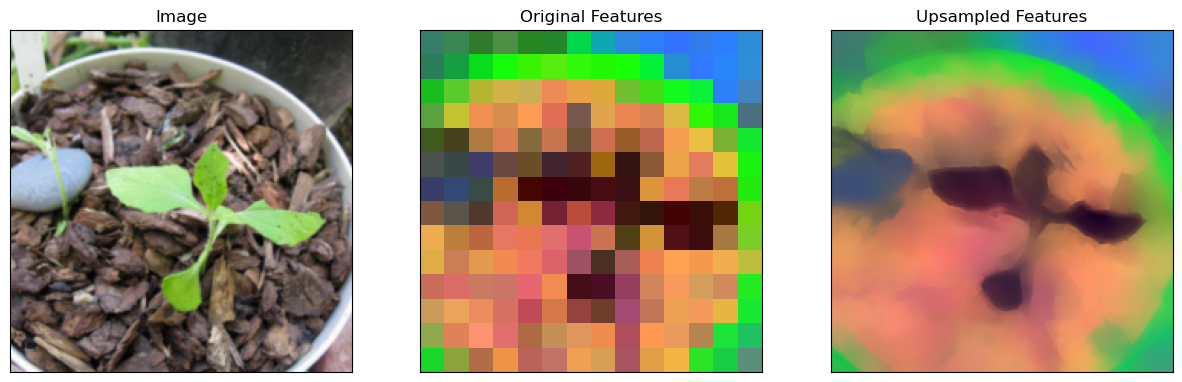

In [9]:
hr_feat = upsmapler(image_tensor)
lr_feat = upsmapler.model(image_tensor)
print(hr_feat.shape, lr_feat.shape)
plot_feats(unnorm(image_tensor)[0], lr_feat[0], hr_feat[0])

In [13]:
first_img = torch.rand(3, 3, 224, 224).to(device)
previous_img = torch.rand(3, 3, 224, 224).to(device)
current_img = torch.rand(3, 3, 224, 224).to(device)
pre_boundary = torch.randint(0, 224, (3, boundary_num, 2)).to(device)
first_boundary = torch.randint(0, 224, (3, boundary_num, 2)).to(device)
pre_boundary.shape

torch.Size([3, 80, 2])

In [14]:
from model import BaseFeatup

In [15]:
model = BaseFeatup().to(device)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
results = model(previous_img, current_img, pre_boundary)

/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
results.shape

torch.Size([3, 80, 2])

In [6]:
first_img_raw_feature = res50_bone(first_img)
first_img_feature = F.interpolate(
    first_img_raw_feature,
    size=(224, 224),
    mode="bilinear",
)
pre_img_raw_feature = res50_bone(previous_img)
pre_img_feature = F.interpolate(
    pre_img_raw_feature,
    size=(224, 224),
    mode="bilinear",
)
cur_img_raw_feature = res50_bone(current_img)
cur_img_feature = F.interpolate(
    cur_img_raw_feature,
    size=(224, 224),
    mode="bilinear",
)
first_img_feature.shape, first_img_raw_feature.shape

(torch.Size([3, 1024, 224, 224]), torch.Size([3, 1024, 14, 14]))

In [41]:
def get_img_tokens(img_features: torch.Tensor) -> torch.Tensor:
    img_tokens = rearrange(
        img_features,
        "b c h w -> b (h w) c",
    )
    return img_tokens
get_img_tokens(first_img_raw_feature).shape

torch.Size([3, 196, 1024])

In [67]:
# first_img_tokens = get_img_tokens(first_img_raw_feature)
# pre_img_tokens = get_img_tokens(pre_img_raw_feature)
cur_img_tokens = get_img_tokens(cur_img_raw_feature)
cur_img_tokens.shape

torch.Size([3, 196, 1024])

In [63]:
d_token = 1024 + 2
positional_encoding = PositionalEncoding(d_token).to(device)
layernorm = nn.LayerNorm(d_token).to(device)
encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_token,
    nhead=1, 
    batch_first=True
).to(device)
tranformer_encoder = nn.TransformerEncoder(
    encoder_layer,
    num_layers=1,
).to(device)

/work3/s232248/miniconda3/envs/vos/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [44]:
img_token_encoder = nn.Linear(1024, d_token).to(device)

In [68]:
cur_img_tokens = img_token_encoder(cur_img_tokens)
cur_img_tokens = layernorm(cur_img_tokens)
cur_img_tokens = positional_encoding(cur_img_tokens)
memory = tranformer_encoder(cur_img_tokens)
memory.shape

torch.Size([3, 196, 1026])

In [46]:
first_query = get_bou_features(first_img_feature, boundary)
first_query = first_query.permute(0, 2, 1)
pre_query = get_bou_features(pre_img_feature, boundary)
pre_query = pre_query.permute(0, 2, 1)
first_query.shape


torch.Size([3, 80, 1024])

In [49]:
query_encoder = nn.Linear(1024, d_token).to(device)

In [57]:
pre_query_tokens = query_encoder(pre_query)
pre_query_tokens = layernorm(pre_query_tokens)
pre_query_tokens = positional_encoding(pre_query_tokens)
pre_query_tokens.shape

torch.Size([3, 80, 1026])

In [58]:
first_query_tokens = query_encoder(first_query)
first_query_tokens = layernorm(first_query_tokens)
first_query_tokens = positional_encoding(first_query_tokens)
first_query_tokens.shape

torch.Size([3, 80, 1026])

In [59]:
boundary_features = get_bou_features(cur_img_feature, boundary)
boundary_features = boundary_features.permute(0, 2, 1)
boundary_features.shape

torch.Size([3, 80, 1024])

In [60]:
boundary_tokens = torch.cat([boundary_features, boundary], dim=2)
boundary_tokens.shape

torch.Size([3, 80, 1026])

In [61]:
boundary_tokens = layernorm(boundary_tokens)
boundary_tokens = positional_encoding(boundary_tokens)
boundary_tokens.shape

torch.Size([3, 80, 1026])

In [62]:
decoder_layer = nn.TransformerDecoderLayer(
    d_model=d_token,
    nhead=1,
    batch_first=True,
).to(device)
transformer_decoder = nn.TransformerDecoder(
    decoder_layer,
    num_layers=1,
).to(device)

In [69]:
input_tokens = torch.cat([
    pre_query_tokens,
    boundary_tokens,
    first_query_tokens
    ], dim=1
)
input_tokens.shape

torch.Size([3, 240, 1026])

In [71]:
out_tokens = transformer_decoder(input_tokens, memory)
out_tokens.shape

torch.Size([3, 240, 1026])

In [72]:
xy_offset_encoder = nn.Linear(d_token, 2).to(device)
q_offset_encoder = nn.Linear(d_token, d_token).to(device)

In [73]:
q_offset = q_offset_encoder(out_tokens[:, :boundary_num, :])
q_offset.shape

torch.Size([3, 80, 1026])

In [74]:
xy_offset = xy_offset_encoder(out_tokens[:, boundary_num:2*boundary_num, :])
xy_offset.shape

torch.Size([3, 80, 2])

In [75]:
(boundary + xy_offset).shape

torch.Size([3, 80, 2])